In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2
#Data handling tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_path = "F:/Mahi/brain mri/7022blur/Training"

filepaths =[]

labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_data_path = 'F:/Mahi/brain mri/7022blur/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
img_size = (224 ,224)
batch_size = 16

ts_gen= ImageDataGenerator()

tr_gen= ImageDataGenerator()
# Create an instance of the ImageDataGenerator

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size, class_mode = 'categorical' ,
                                      color_mode= 'rgb', shuffle = False , batch_size = batch_size)

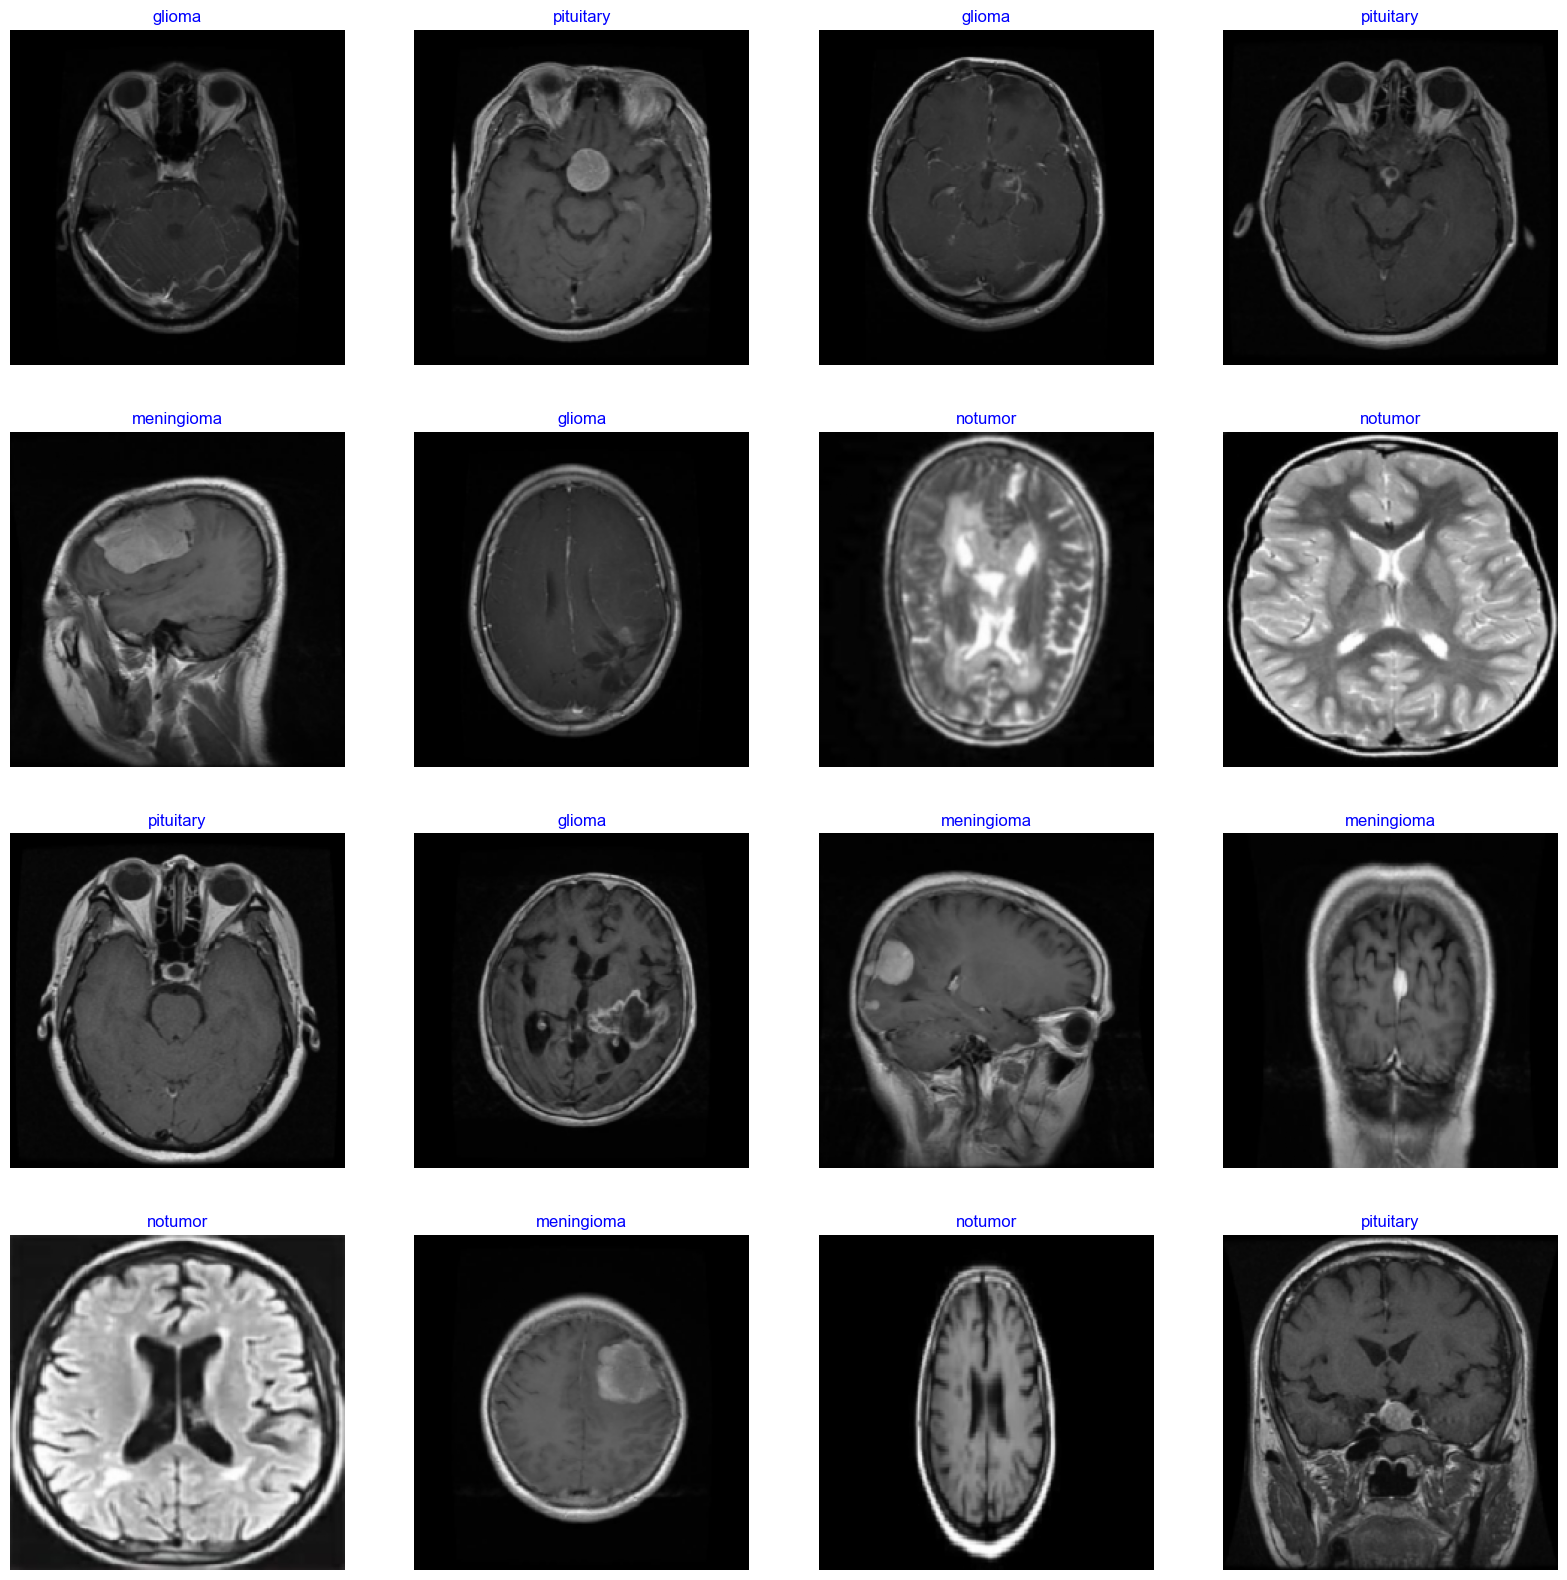

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
#plt.savefig("/content/drive/MyDrive/Dataset.jpg")
plt.show();
# plt.savefig("/content/drive/MyDrive/Dataset.jpg")

In [ ]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# Specify the path to save the best model weights
checkpoint_filepath = 'F:\\Mahi\\brain mri\\cnn7022.h5'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
# Set up the ModelCheckpoint callback to save weights with the highest validation accuracy
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
from tensorflow.keras.applications import DenseNet201
model3 = Sequential()
model3.add(DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

74836368/74836368 [==============================] - 5s 0us/step
Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 3.2157 - accuracy: 0.6140
Epoch 1: val_accuracy improved from -inf to 0.30892, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 46s 232ms/step - loss: 3.2157 - accuracy: 0.6140 - val_loss: 9778019.0000 - val_accuracy: 0.3089 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 3.8873 - accuracy: 0.5861
Epoch 2: val_accuracy improved from 0.30892 to 0.32571, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 22s 183ms/step - loss: 3.8873 - accuracy: 0.5861 - val_loss: 4682.9556 - val_accuracy: 0.3257 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 3.9064 - accuracy: 0.6633
Epoch 3: val_accuracy did not improve from 0.32571
119/119 [==============================] - 15s 126ms/step - loss: 3.9064 - accuracy: 0.6633

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.943333  0.975862  0.959322       290
           1   0.947712  0.941558  0.944625       308
           2   0.997531  0.985366  0.991411       410
           3   0.993333  0.983498  0.988391       303

    accuracy                       0.972540      1311
   macro avg   0.970477  0.971571  0.970937      1311
weighted avg   0.972868  0.972540  0.972623      1311



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#DenseNet169

In [ ]:
from tensorflow.keras.applications import DenseNet169
model3 = Sequential()
model3.add(DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 4.2895 - accuracy: 0.5037
Epoch 1: val_accuracy improved from -inf to 0.30892, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 39s 195ms/step - loss: 4.2895 - accuracy: 0.5037 - val_loss: 2452463.5000 - val_accuracy: 0.3089 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 4.4907 - accuracy: 0.4900
Epoch 2: val_accuracy did not improve from 0.30892
119/119 [==============================] - 13s 110ms/step - loss: 4.4907 - accuracy: 0.4900 - val_loss: 445534.0312 - val_accuracy: 0.3082 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 4.1277 - accuracy: 0.5494
Epoch 3: val_accuracy did not improve from 0.30892
119/119 [==============================] - 13s 110ms/step - loss: 4.1277 - accuracy: 0.5494 - val_loss: 28.7729 - val_accuracy: 0.2632 - lr: 0.0010
Epoch 4/100
119/119 [==============================] - E

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.936667  0.975694  0.955782       288
           1   0.924837  0.933993  0.929392       303
           2   1.000000  0.985401  0.992647       411
           3   0.990000  0.961165  0.975369       309

    accuracy                       0.965675      1311
   macro avg   0.962876  0.964064  0.963298      1311
weighted avg   0.966358  0.965675  0.965857      1311



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#ResNet50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2
model3 = Sequential()
model3.add(ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
118/119 [============================>.] - ETA: 0s - loss: 1.9656 - accuracy: 0.6229
Epoch 1: val_accuracy improved from -inf to 0.31045, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 19s 95ms/step - loss: 1.9685 - accuracy: 0.6213 - val_loss: 832422.0625 - val_accuracy: 0.3105 - lr: 0.0010
Epoch 2/100
118/119 [============================>.] - ETA: 0s - loss: 1.5447 - accuracy: 0.6864
Epoch 2: val_accuracy did not improve from 0.31045
119/119 [==============================] - 7s 54ms/step - loss: 1.5371 - accuracy: 0.6880 - val_loss: 447.9406 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 1.4804 - accuracy: 0.7012
Epoch 3: val_accuracy improved from 0.31045 to 0.37529, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 11s 89ms/step - loss: 1.4804 - accuracy: 0.7012 - val_loss: 922.3488 - val_accuracy: 0.3753 - lr: 0.0010
Epoch 4/100
1

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.906667  0.937931  0.922034       290
           1   0.872549  0.902027  0.887043       296
           2   1.000000  0.961995  0.980630       421
           3   0.980000  0.967105  0.973510       304

    accuracy                       0.944317      1311
   macro avg   0.939804  0.942265  0.940804      1311
weighted avg   0.945940  0.944317  0.944887      1311



In [ ]:
#ResNet101V2
#

In [ ]:
from tensorflow.keras.applications import ResNet101V2
model3 = Sequential()
model3.add(ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

171317808/171317808 [==============================] - 12s 0us/step
Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 2.8445 - accuracy: 0.4396
Epoch 1: val_accuracy improved from -inf to 0.36918, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 30s 154ms/step - loss: 2.8445 - accuracy: 0.4396 - val_loss: 663361280.0000 - val_accuracy: 0.3692 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 2.8941 - accuracy: 0.3230
Epoch 2: val_accuracy did not improve from 0.36918
119/119 [==============================] - 9s 77ms/step - loss: 2.8941 - accuracy: 0.3230 - val_loss: 124329.0703 - val_accuracy: 0.3066 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 3.2904 - accuracy: 0.2988
Epoch 3: val_accuracy did not improve from 0.36918
119/119 [==============================] - 9s 78ms/step - loss: 3.2904 - accuracy: 0.2988 - val_loss: 23401.5508 - val_accuracy: 0.2006 

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.716667  0.853175  0.778986       252
           1   0.480392  0.622881  0.542435       236
           2   0.940741  0.830065  0.881944       459
           3   0.953333  0.785714  0.861446       364

    accuracy                       0.784897      1311
   macro avg   0.772783  0.772959  0.766203      1311
weighted avg   0.818296  0.784897  0.795345      1311



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#ResNet152V2

In [ ]:
from tensorflow.keras.applications import ResNet152V2
model3 = Sequential()
model3.add(ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

234545216/234545216 [==============================] - 16s 0us/step
Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 2.0362 - accuracy: 0.4228
Epoch 1: val_accuracy improved from -inf to 0.29596, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 41s 217ms/step - loss: 2.0362 - accuracy: 0.4228 - val_loss: 483059872.0000 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 2.3834 - accuracy: 0.3230
Epoch 2: val_accuracy improved from 0.29596 to 0.30664, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 24s 198ms/step - loss: 2.3834 - accuracy: 0.3230 - val_loss: 42813.7930 - val_accuracy: 0.3066 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 4.4250 - accuracy: 0.3277
Epoch 3: val_accuracy improved from 0.30664 to 0.30892, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==========================

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.956667  0.937908  0.947195       306
           1   0.898693  0.932203  0.915141       295
           2   0.987654  0.987654  0.987654       405
           3   0.990000  0.973770  0.981818       305

    accuracy                       0.960336      1311
   macro avg   0.958253  0.957884  0.957952      1311
weighted avg   0.960949  0.960336  0.960536      1311



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
model3 = Sequential()
model3.add(VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

80134624/80134624 [==============================] - 5s 0us/step
Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 9.5204 - accuracy: 0.3834
Epoch 1: val_accuracy improved from -inf to 0.47292, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 17s 91ms/step - loss: 9.5204 - accuracy: 0.3834 - val_loss: 1.1460 - val_accuracy: 0.4729 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.9971 - accuracy: 0.5693
Epoch 2: val_accuracy improved from 0.47292 to 0.51564, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 10s 84ms/step - loss: 0.9971 - accuracy: 0.5693 - val_loss: 1.0721 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.8331 - accuracy: 0.6402
Epoch 3: val_accuracy improved from 0.51564 to 0.59497, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 10s 84ms/

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.936667  0.972318  0.954160       289
           1   0.944444  0.932258  0.938312       310
           2   1.000000  0.985401  0.992647       411
           3   0.990000  0.986711  0.988353       301

    accuracy                       0.970252      1311
   macro avg   0.967778  0.969172  0.968368      1311
weighted avg   0.970606  0.970252  0.970329      1311



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
model3 = Sequential()
model3.add(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

119/119 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9386
Epoch 30: val_accuracy did not improve from 0.89092
119/119 [==============================] - 9s 71ms/step - loss: 0.1779 - accuracy: 0.9386 - val_loss: 0.3134 - val_accuracy: 0.8856 - lr: 2.0000e-04
Epoch 31/100
118/119 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9428
Epoch 31: val_accuracy did not improve from 0.89092
119/119 [==============================] - 8s 71ms/step - loss: 0.1604 - accuracy: 0.9412 - val_loss: 0.2658 - val_accuracy: 0.8886 - lr: 2.0000e-04
Epoch 32/100
119/119 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9317
Epoch 32: val_accuracy did not improve from 0.89092
119/119 [==============================] - 8s 71ms/step - loss: 0.1879 - accuracy: 0.9317 - val_loss: 0.2997 - val_accuracy: 0.8871 - lr: 2.0000e-04
Epoch 33/100
119/119 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9438
Epoch 33: val_accu

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.883333  0.946429  0.913793       280
           1   0.921569  0.881250  0.900958       320
           2   1.000000  0.990220  0.995086       409
           3   0.980000  0.973510  0.976744       302

    accuracy                       0.950420      1311
   macro avg   0.946225  0.947852  0.946645      1311
weighted avg   0.951331  0.950420  0.950523      1311



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
model3 = Sequential()
model3.add(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
118/119 [============================>.] - ETA: 0s - loss: 1.9578 - accuracy: 0.7415
Epoch 1: val_accuracy improved from -inf to 0.23341, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 18s 92ms/step - loss: 1.9467 - accuracy: 0.7416 - val_loss: 71.5492 - val_accuracy: 0.2334 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 1.6008 - accuracy: 0.7663
Epoch 2: val_accuracy improved from 0.23341 to 0.30892, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 10s 85ms/step - loss: 1.6008 - accuracy: 0.7663 - val_loss: 33.5079 - val_accuracy: 0.3089 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 1.0438 - accuracy: 0.8146
Epoch 3: val_accuracy did not improve from 0.30892
119/119 [==============================] - 6s 54ms/step - loss: 1.0438 - accuracy: 0.8146 - val_loss: 

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.986667  0.976898  0.981758       303
           1   0.970588  0.973770  0.972177       305
           2   0.997531  0.997531  0.997531       405
           3   0.990000  0.996644  0.993311       298

    accuracy                       0.987033      1311
   macro avg   0.986196  0.986211  0.986194      1311
weighted avg   0.987040  0.987033  0.987028      1311



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')